<a href="https://colab.research.google.com/github/akanshgupta98/Audio-Emotion-Recognition/blob/master/Copy_of_Parallel_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np


# Dataset

In [ ]:
!wget https://raw.githubusercontent.com/akanshgupta98/Audio-Emotion-Recognition/master/audio.csv

--2020-06-04 11:58:55--  https://raw.githubusercontent.com/akanshgupta98/Audio-Emotion-Recognition/master/audio.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1638483 (1.6M) [text/plain]
Saving to: ‘audio.csv’

audio.csv           100%[===================>]   1.56M  3.86MB/s    in 0.4s    

2020-06-04 11:58:57 (3.86 MB/s) - ‘audio.csv’ saved [1638483/1638483]



In [ ]:
data = pd.read_csv('audio.csv')
print(data.shape)

(1440, 61)


In [ ]:
data_copy = data.copy()

In [ ]:
X_cnn=data_copy.drop('name label emotion chroma_stft_mean rmse_mean spec_cent_mean spec_bw_mean rolloff_mean zcr_mean chroma1 chroma2 chroma3 chroma4 chroma5 chroma6 chroma7 chroma8 chroma9 chroma10 chroma11 chroma12'.split(),axis=1)

In [ ]:
print(X_cnn.shape)

(1440, 40)


In [ ]:
#tried the encoder of sklearn and compared with manual encoding. results had no huge difference.
encoder = LabelEncoder()
Y =  encoder.fit_transform(data_copy['label'])
Y

array([0, 0, 0, ..., 7, 7, 7])

# Train-Test-Split

In [ ]:
X_train_cnn,X_test_cnn,Y_train_cnn,Y_test_cnn=train_test_split(X_cnn,Y,random_state=1,stratify=Y,test_size=0.20)

In [ ]:
scaler=StandardScaler()
X_scaled_train_cnn=scaler.fit_transform(X_train_cnn)
X_scaled_test_cnn=scaler.transform(X_test_cnn)

In [ ]:
X_expanded_scaled_train_cnn = np.expand_dims(X_scaled_train_cnn, axis=2)
X_expanded_scaled_test_cnn = np.expand_dims(X_scaled_test_cnn, axis=2)

In [ ]:
X_expanded_scaled_train_cnn.shape, X_expanded_scaled_test_cnn.shape

((1152, 40, 1), (288, 40, 1))

In [ ]:
X_scaled_train_cnn.shape

(1152, 40)

# Parallel Approach

## Model 1

In [ ]:
input_shape = Input(shape=(40, 1))
layer1 = Conv1D(128,8,padding='same',activation='relu')(input_shape)
layer1 = MaxPooling1D(pool_size=5)(layer1)
layer1 = Conv1D(256,8,padding='same',activation='relu')(layer1)
layer1 = MaxPooling1D(pool_size=5)(layer1)
print(layer1.shape)


(None, 1, 256)


## Model 2

In [ ]:
layer2 = Conv1D(64,8,padding='same',activation='relu')(input_shape)
layer2 = MaxPooling1D(pool_size=5)(layer2)
layer2 = Conv1D(256,8,padding='same',activation='relu')(layer2)
layer2 = MaxPooling1D(pool_size=5)(layer2)


print(layer2.shape)

(None, 1, 256)


## Concatenating 2 models into 1

In [ ]:
merged = keras.layers.concatenate([layer1,layer2], axis=1)
merged = Flatten()(merged)

## Fully Connected Layer

In [ ]:
out = Dense(256, activation='relu')(merged)
out = Dense(256,activation='relu')(out)
out = Dense(8, activation='softmax')(out)

model = Model(input_shape, out)

In [ ]:
opt = keras.optimizers.rmsprop(lr=0.0003, rho=0.9, decay=0.0)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Training Model

In [ ]:
cnnhistory=model.fit(X_expanded_scaled_train_cnn, Y_train_cnn, batch_size=128, epochs=200, validation_data=(X_expanded_scaled_test_cnn, Y_test_cnn))

Train on 1152 samples, validate on 288 samples
Epoch 1/200
1152/1152 [==============================] - 2s 2ms/step - loss: 2.0205 - accuracy: 0.1901 - val_loss: 1.9635 - val_accuracy: 0.2431
Epoch 2/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.9146 - accuracy: 0.2526 - val_loss: 1.9099 - val_accuracy: 0.2257
Epoch 3/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.8621 - accuracy: 0.2830 - val_loss: 1.8945 - val_accuracy: 0.2743
Epoch 4/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.8055 - accuracy: 0.3108 - val_loss: 1.9081 - val_accuracy: 0.2535
Epoch 5/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.7866 - accuracy: 0.3186 - val_loss: 1.8737 - val_accuracy: 0.2361
Epoch 6/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.7290 - accuracy: 0.3646 - val_loss: 1.8826 - val_accuracy: 0.2431
Epoch 7/200
1152/1152 [==============================] - 2s 1ms/step - loss: 1.7102

In [ ]:
Y_pred_cnn = model.predict(X_expanded_scaled_test_cnn)

In [ ]:
Y_pred_cnn = np.argmax(Y_pred_cnn,axis=1)

In [ ]:
Y_pred_cnn

array([6, 1, 1, 3, 4, 0, 5, 7, 4, 5, 5, 4, 1, 1, 1, 2, 2, 0, 1, 3, 6, 4,
       2, 2, 5, 7, 7, 3, 3, 6, 1, 3, 7, 6, 0, 3, 3, 1, 3, 5, 3, 4, 1, 7,
       6, 5, 1, 4, 1, 4, 5, 7, 5, 1, 1, 7, 5, 3, 1, 6, 1, 5, 4, 4, 6, 7,
       2, 5, 1, 1, 1, 4, 4, 2, 6, 1, 2, 1, 1, 7, 6, 5, 2, 2, 0, 3, 1, 5,
       1, 6, 6, 6, 3, 2, 3, 1, 2, 2, 7, 3, 4, 5, 2, 6, 4, 1, 3, 6, 1, 2,
       1, 6, 0, 3, 5, 4, 1, 6, 5, 7, 5, 4, 3, 7, 6, 3, 5, 1, 3, 4, 5, 7,
       1, 0, 4, 4, 2, 3, 2, 2, 1, 5, 0, 7, 7, 2, 6, 1, 1, 0, 7, 4, 5, 1,
       4, 3, 6, 3, 6, 7, 1, 2, 5, 5, 6, 3, 2, 4, 1, 5, 1, 2, 5, 2, 7, 4,
       4, 7, 7, 5, 6, 7, 1, 4, 7, 2, 5, 6, 6, 5, 4, 4, 2, 7, 2, 7, 2, 3,
       6, 3, 7, 3, 4, 4, 3, 5, 1, 1, 7, 2, 1, 1, 5, 1, 6, 7, 3, 4, 1, 1,
       4, 3, 3, 3, 0, 4, 2, 7, 4, 3, 5, 7, 3, 6, 6, 7, 2, 3, 3, 5, 1, 1,
       1, 1, 0, 4, 5, 4, 7, 3, 3, 3, 3, 4, 4, 4, 3, 4, 6, 1, 1, 5, 2, 5,
       3, 7, 7, 2, 3, 4, 6, 5, 1, 2, 5, 2, 4, 3, 3, 1, 7, 2, 1, 1, 3, 5,
       4, 4])

In [ ]:
Y_test_cnn

array([6, 3, 1, 3, 4, 5, 3, 3, 4, 7, 7, 6, 1, 1, 1, 2, 2, 0, 5, 6, 6, 4,
       2, 6, 5, 6, 7, 6, 3, 6, 1, 3, 7, 6, 0, 2, 3, 1, 0, 6, 3, 4, 1, 7,
       3, 5, 1, 5, 0, 4, 5, 2, 5, 0, 1, 3, 5, 3, 1, 6, 6, 2, 2, 4, 6, 7,
       3, 5, 3, 4, 1, 4, 4, 6, 6, 5, 2, 1, 1, 7, 6, 5, 2, 5, 5, 3, 0, 3,
       1, 4, 4, 6, 4, 7, 3, 1, 2, 2, 7, 0, 6, 5, 0, 6, 4, 3, 3, 7, 0, 2,
       1, 6, 6, 2, 7, 4, 1, 6, 5, 7, 6, 4, 3, 7, 6, 1, 7, 4, 3, 2, 5, 7,
       1, 0, 4, 4, 6, 3, 2, 2, 1, 5, 0, 7, 7, 0, 6, 1, 1, 0, 7, 5, 5, 1,
       4, 3, 6, 2, 2, 7, 0, 2, 5, 5, 6, 3, 7, 4, 1, 5, 1, 5, 5, 5, 2, 2,
       4, 7, 7, 5, 6, 2, 1, 6, 7, 6, 5, 6, 4, 5, 4, 4, 2, 7, 6, 7, 5, 5,
       6, 6, 7, 3, 4, 4, 6, 3, 1, 1, 5, 2, 4, 7, 5, 1, 6, 4, 4, 2, 1, 3,
       7, 3, 3, 3, 0, 4, 2, 7, 4, 3, 2, 7, 0, 2, 1, 7, 2, 3, 0, 5, 1, 1,
       0, 6, 7, 7, 5, 4, 7, 3, 3, 3, 5, 4, 4, 4, 2, 2, 4, 1, 1, 5, 2, 4,
       7, 7, 0, 2, 2, 6, 7, 5, 1, 2, 5, 2, 2, 3, 3, 1, 7, 2, 1, 3, 3, 5,
       4, 4])

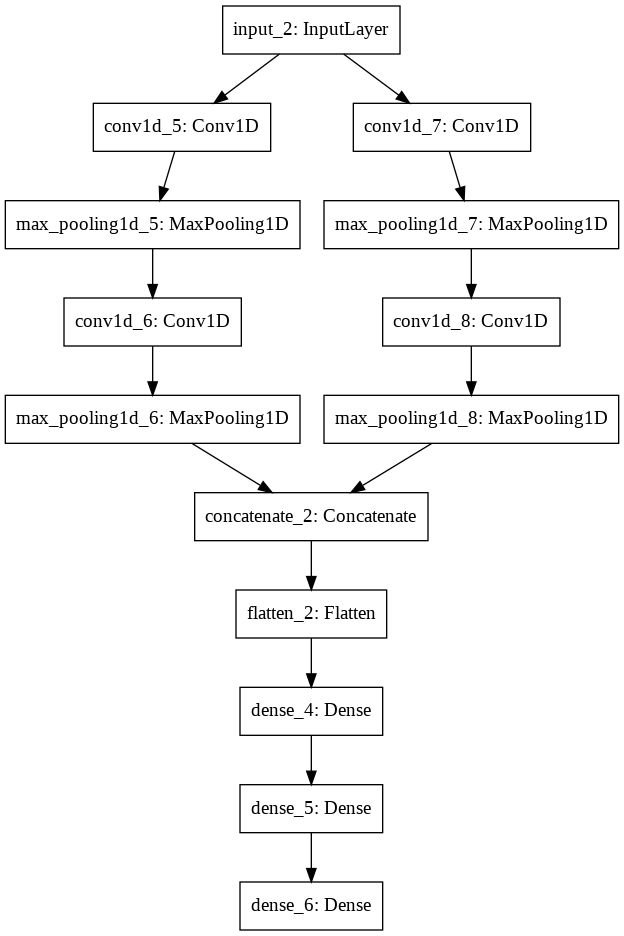

In [ ]:
keras.utils.plot_model(model)

# Classification Report

In [ ]:
print(classification_report(Y_test_cnn,Y_pred_cnn))

              precision    recall  f1-score   support

           0       0.60      0.32      0.41        19
           1       0.65      0.95      0.77        38
           2       0.59      0.53      0.56        38
           3       0.58      0.68      0.63        38
           4       0.67      0.72      0.69        39
           5       0.68      0.67      0.68        39
           6       0.67      0.51      0.58        39
           7       0.74      0.66      0.69        38

    accuracy                           0.65       288
   macro avg       0.65      0.63      0.63       288
weighted avg       0.65      0.65      0.64       288



# ROC-AUC Curve

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_test_one_hot_cnn = enc.fit_transform(np.expand_dims(Y_test_cnn,1)).toarray()
Y_test_one_hot_cnn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Y_pred_cnn = model.predict(X_expanded_scaled_test_cnn)
print(Y_pred_cnn.shape)
print(Y_test_one_hot_cnn.shape)

(288, 8)
(288, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


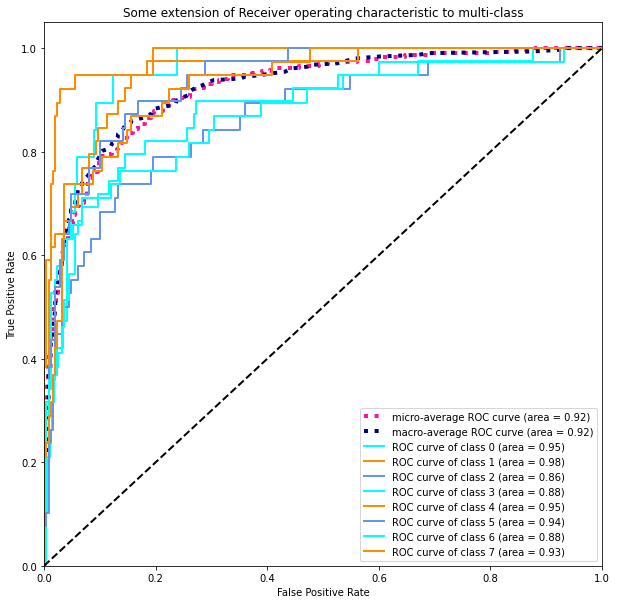

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes=8
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot_cnn[:, i], Y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_one_hot_cnn.ravel(), Y_pred_cnn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1,figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:


# model = Sequential()

# model.add(Conv1D(64, 8,padding='same',   
#                  input_shape=(40,1)))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Conv1D(128, 8,padding='same',))
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=(5)))
